In [1]:
import os, sys
import torch, json
import numpy as np

from detr_utils import build_model
from dino_utils.slconfig import SLConfig
from dataset_utils.coco import build_dataset
from dino_utils.visualizer import COCOVisualizer
from dino_utils import box_ops
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

%load_ext autoreload
%autoreload 2

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Example usage
seed = 42
set_seed(seed)

In [2]:
# adapted from https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb#scrollTo=eg4RK8JiYTEl
import torchvision.transforms as T
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).cuda()
    return b


def visualize_decoder_weights(model, img, mode="single", caption="Image"):
    transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
    ]
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    # mean-std normalize the input image (batch-size: 1)
    #img = transform(im).unsqueeze(0)

    # propagate through the model
    outputs = model(img.unsqueeze(0).cuda())

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.3

    # convert boxes from [0; 1] to image scales
    print("Size is", img.shape)
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], (img.shape[2], img.shape[1]))
    
    # use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []

    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, inp, output: conv_features.append(output)
        ),
        model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
            lambda self, inp, output: enc_attn_weights.append(output[1])
        ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, inp, output: dec_attn_weights.append(output[1])
        ),
    ]
    
    # propagate through the model
    outputs = model(img.unsqueeze(0).cuda())

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[0]
    dec_attn_weights = dec_attn_weights[0]
    
    # get the feature map shape
    h, w = conv_features['0'].tensors.shape[-2:]

    print("There are", len(bboxes_scaled), "objects in the figure")
    img = img.permute(1, 2, 0)
    img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
    plt.clf()
    
    if mode == "multi":
        fig, ax = plt.subplots(ncols=2, nrows=len(bboxes_scaled), figsize=(2*5, len(bboxes_scaled) * 5))
        colors = COLORS * 100
        i = 0

        for idx, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), bboxes_scaled.detach().cpu().numpy()):
            if len(bboxes_scaled) > 1:
        #         ax = ax_i[0]
                ax[i,0].imshow(dec_attn_weights[0, idx].view(h, w).detach().cpu().numpy())
                ax[i,0].axis('off')
                ax[i,0].set_title(f'query id: {idx.item()}')
                #ax = ax_i[1]
                ax[i,1].imshow(img)
                ax[i,1].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                           fill=False, color='blue', linewidth=3))
                ax[i,1].axis('off')
                ax[i,1].set_title(CLASSES[probas[idx].argmax()])
                i += 1
            else:
                ax[0].imshow(dec_attn_weights[0, idx].view(h, w).detach().cpu().numpy())
                ax[0].axis('off')
                ax[0].set_title(f'query id: {idx.item()}')
                #ax = ax_i[1]
                ax[1].imshow(img)
                ax[1].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                           fill=False, color='blue', linewidth=3))
                ax[1].axis('off')
                ax[1].set_title(CLASSES[probas[idx].argmax()])
                i += 1
        fig.tight_layout()
        plt.show()
    
    else:
        # Use the built-in COCO visualizer
        output = postprocessors['bbox'](outputs, torch.Tensor([[1.0, 1.0]]).cuda())[0]

        threshold = 0.5 # set a thershold

        scores = output['scores']
        labels = output['labels']
        boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
        select_mask = scores > threshold
        box_label = [id2name[int(item)] for item in labels[select_mask]]
        pred_dict = {
            'boxes': boxes[select_mask],
            'size': targets['size'],
            'box_label': box_label
        }
        vslzr = COCOVisualizer()
        vslzr.visualize(image, pred_dict, savedir=None, caption="Image (" + caption + ")")
 
        # Now plot the decoder's attention weights
        #fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
        total_weights = np.zeros(dec_attn_weights[0, 0].view(h, w).detach().cpu().numpy().shape)
        for idx, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), bboxes_scaled.detach().cpu().numpy()):
            total_weights += dec_attn_weights[0, idx].view(h, w).detach().cpu().numpy()
            #ax[1].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='blue', linewidth=3))

        plt.imshow(total_weights)
        plt.axis('off')
        plt.title("Decoder Attention Weights (" + caption + ")")
        plt.show()

def visualize_encoder_weights(model, img, idxs):
    transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
    ]
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    # mean-std normalize the input image (batch-size: 1)
    #img = transform(im).unsqueeze(0)

    # propagate through the model
    outputs = model(img.unsqueeze(0).cuda())

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.3

    # convert boxes from [0; 1] to image scales
    print("Size is", img.shape)
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], (img.shape[2], img.shape[1]))
    
    # use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []

    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, inp, output: conv_features.append(output)
        ),
        model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
            lambda self, inp, output: enc_attn_weights.append(output[1])
        ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, inp, output: dec_attn_weights.append(output[1])
        ),
    ]
    
    # propagate through the model
    outputs = model(img.unsqueeze(0).cuda())

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[0]
    dec_attn_weights = dec_attn_weights[0]
    
    f_map = conv_features['0']
    print("Encoder attention:      ", enc_attn_weights[0].shape)
    print("Feature map:            ", f_map.tensors.shape)
    
    # get the HxW shape of the feature maps of the CNN
    shape = f_map.tensors.shape[-2:]
    # and reshape the self-attention to a more interpretable shape
    sattn = enc_attn_weights[0].reshape(shape + shape)
    print("Reshaped self-attention:", sattn.shape)
    
    # downsampling factor for the CNN, is 32 for DETR and 16 for DETR DC5
    fact = 32
    
    img = img.permute(1, 2, 0)
    img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))

    # here we create the canvas
    plt.clf()
    fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
    # and we add one plot per reference point
    gs = fig.add_gridspec(2, 4)
    axs = [
        fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[0, -1]),
        fig.add_subplot(gs[1, -1]),
    ]

    # for each one of the reference points, let's plot the self-attention
    # for that point
    for idx_o, ax in zip(idxs, axs):
        idx = (idx_o[0] // fact, idx_o[1] // fact)
        ax.imshow(sattn[..., idx[0], idx[1]].detach().cpu().numpy(), cmap='cividis', interpolation='nearest')
        ax.axis('off')
        ax.set_title(f'self-attention{idx_o}')

    # and now let's add the central image, with the reference points as red circles
    fcenter_ax = fig.add_subplot(gs[:, 1:-1])
    fcenter_ax.imshow(img.detach().cpu().numpy())
    for (y, x) in idxs:
        scale = img.shape[0] / img.shape[-2]
        x = ((x // fact) + 0.5) * fact
        y = ((y // fact) + 0.5) * fact
        fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
        fcenter_ax.axis('off')
    plt.show()
    
    

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
--- NORMAL IMAGE ---
Size is torch.Size([3, 800, 1060])
There are 78 objects in the figure


<Figure size 640x480 with 0 Axes>

<Figure size 1750x595 with 0 Axes>

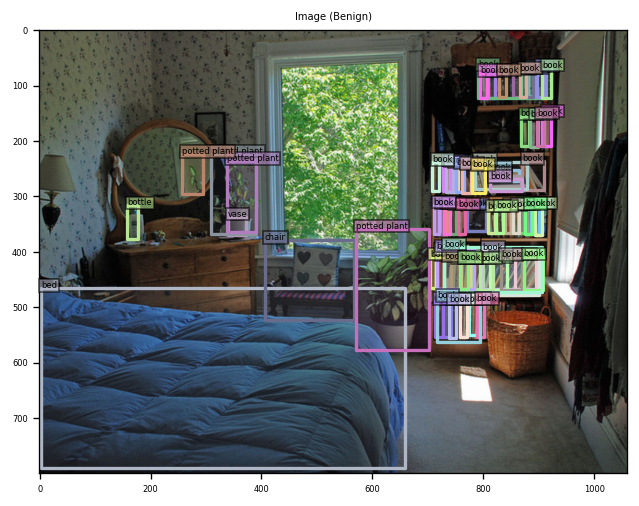

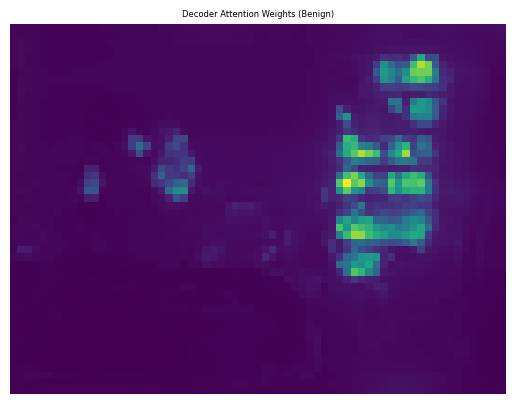

Size is torch.Size([3, 800, 1060])
Encoder attention:       torch.Size([3350, 3350])
Feature map:             torch.Size([1, 2048, 50, 67])
Reshaped self-attention: torch.Size([50, 67, 50, 67])


<Figure size 640x480 with 0 Axes>

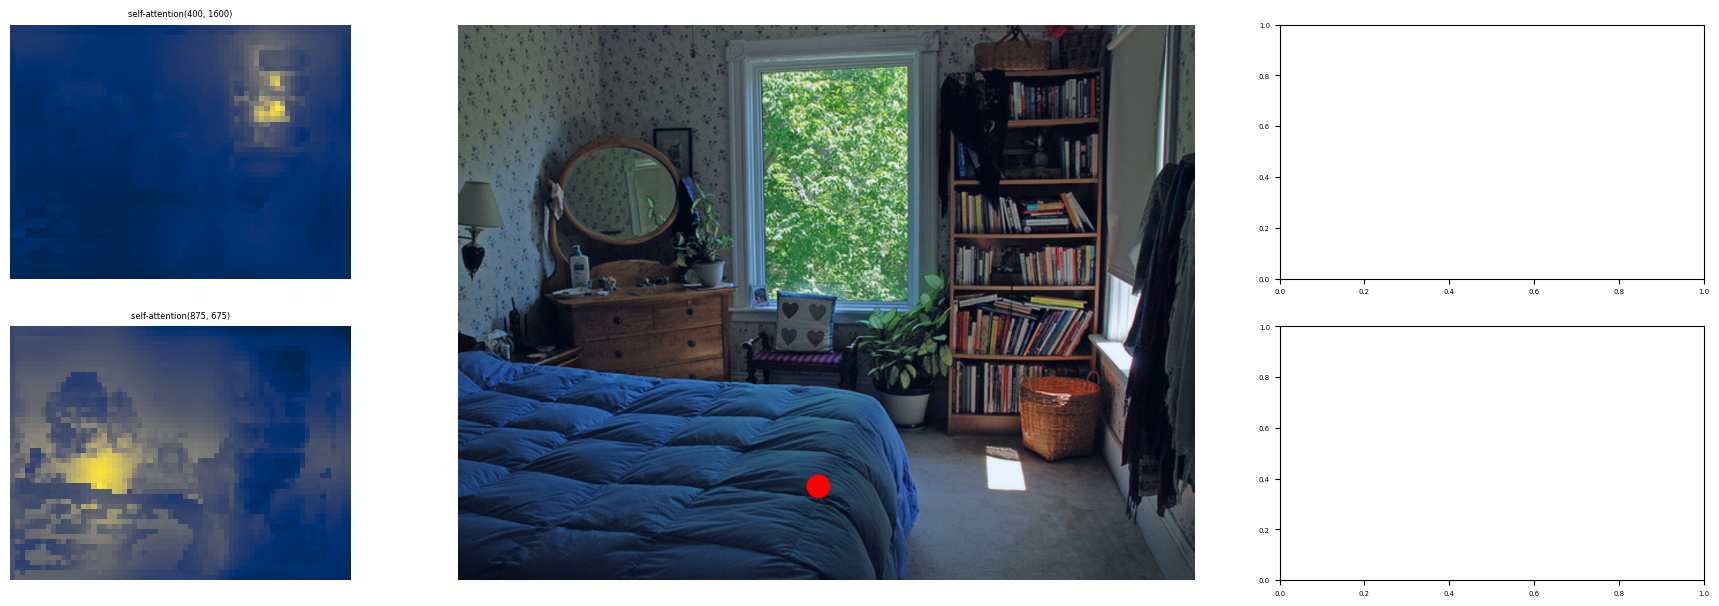

--- ATTACKED ---
Detections are torch.return_types.sort(
values=tensor([0.0051, 0.0064, 0.0064, 0.0066, 0.0095, 0.0188, 0.0201, 0.0205, 0.0256,
        0.0262, 0.0271, 0.0283, 0.0519, 0.0558, 0.0603, 0.0724, 0.0763, 0.0765,
        0.0814, 0.1178, 0.2341, 0.2651, 0.3078, 0.3917, 0.4230, 0.4234, 0.4706,
        0.5012, 0.5046, 0.5369, 0.5380, 0.5773, 0.5940, 0.6004, 0.6060, 0.6099,
        0.6502, 0.6611, 0.6621, 0.6711, 0.6752, 0.6796, 0.6917, 0.6937, 0.6960,
        0.6960, 0.6962, 0.7010, 0.7027, 0.7029, 0.7035, 0.7044, 0.7098, 0.7102,
        0.7104, 0.7158, 0.7216, 0.7246, 0.7252, 0.7272, 0.7307, 0.7322, 0.7383,
        0.7468, 0.7481, 0.7561, 0.7603, 0.7636, 0.7649, 0.7655, 0.7674, 0.7781,
        0.7819, 0.7831, 0.7861, 0.7885, 0.7993, 0.8027, 0.8094, 0.8105, 0.8109,
        0.8119, 0.8135, 0.8178, 0.8189, 0.8207, 0.8221, 0.8235, 0.8404, 0.8424,
        0.8436, 0.8439, 0.8563, 0.8750, 0.8833, 0.9849, 0.9905, 0.9963, 0.9972,
        0.9990], device='cuda:0', grad_fn=<SortBackward0

<Figure size 640x480 with 0 Axes>

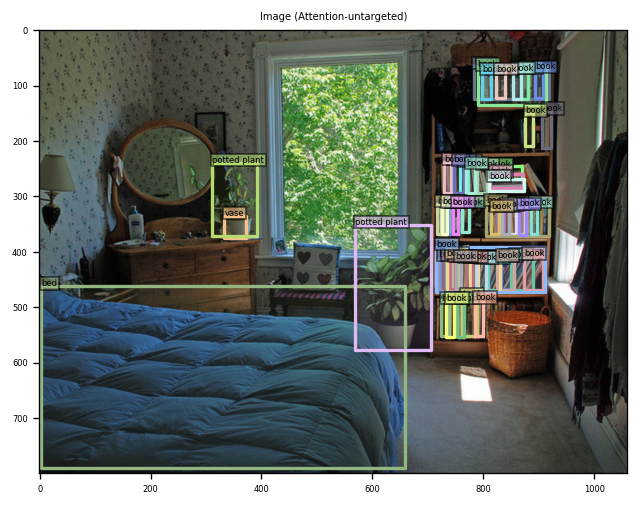

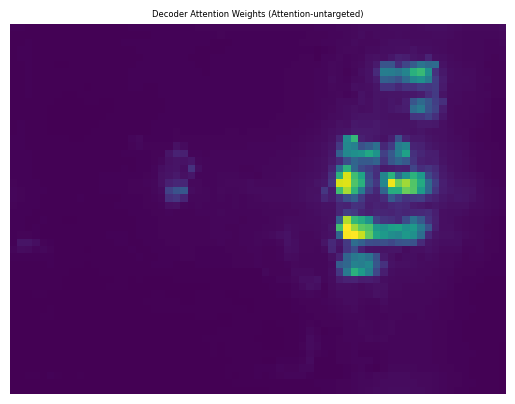

Size is torch.Size([3, 800, 1060])
Encoder attention:       torch.Size([3350, 3350])
Feature map:             torch.Size([1, 2048, 50, 67])
Reshaped self-attention: torch.Size([50, 67, 50, 67])


<Figure size 640x480 with 0 Axes>

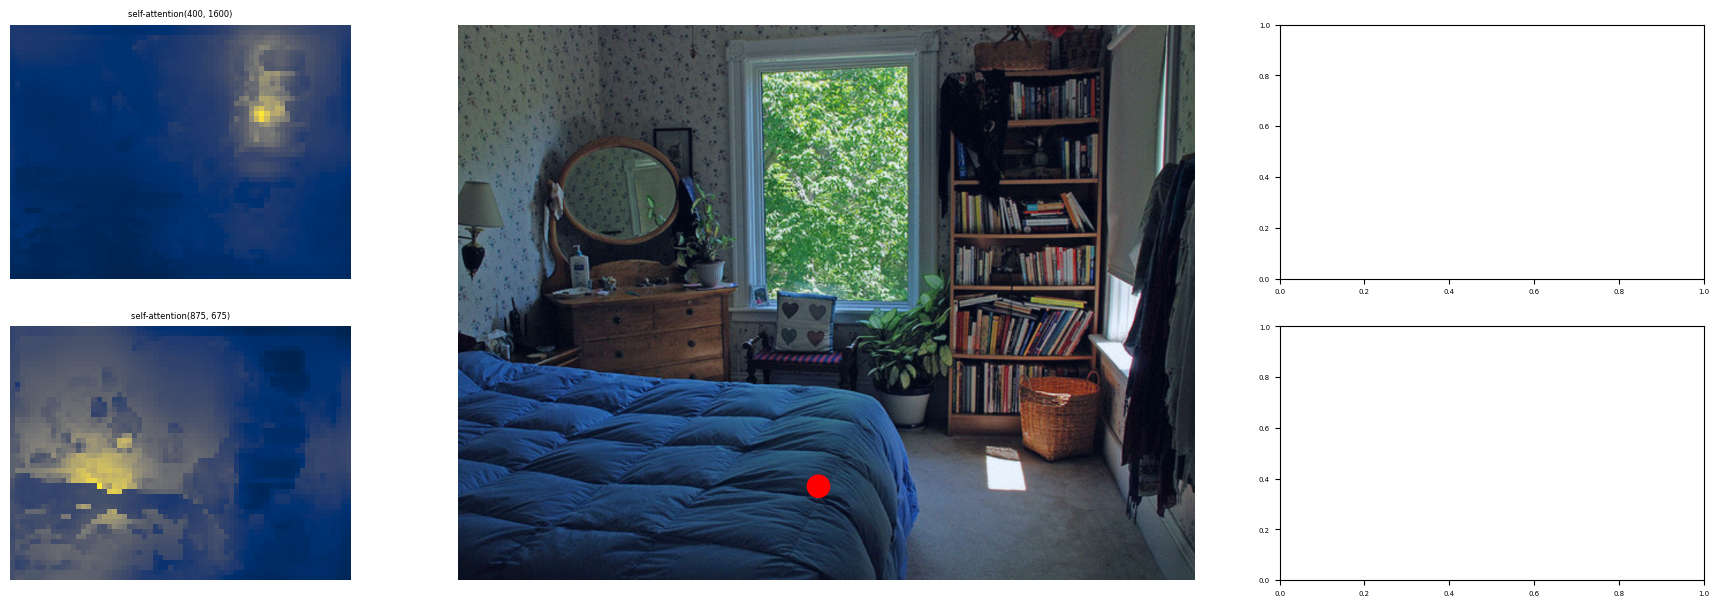

In [8]:
model_config_path = "detr_utils/config/r50_config.py"
model_checkpoint_path = "model_files/detr-r50.pth"
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda'
args.masks = False
args.resume="resnet50"
model, criterion, postprocessors = build_model(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu', weights_only=True)
_ = model.eval()
model.postprocessors = postprocessors
model.load_state_dict(checkpoint['model'])
model.to(torch.device('cuda'))
model.criterion = criterion
# load coco names
with open('dino_utils/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}
    
args.dataset_file = 'coco'
args.coco_path = "dataset/coco/" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)   

print("--- NORMAL IMAGE ---")
image, targets = dataset_val[2]
visualize_decoder_weights(model, image, mode="single", caption="Benign")
idxs = [(400, 1600), (875, 675),]
visualize_encoder_weights(model, image, idxs)

print("--- ATTACKED ---")
from tog.attacks import tog_attention
image_attn = tog_attention(model, image.unsqueeze(0).float(), n_iter=3, mode="untargeted")
visualize_decoder_weights(model, image_attn.squeeze().float(), mode="single", caption="Attention-untargeted")
visualize_encoder_weights(model, image_attn.squeeze().float(), idxs)